In [1]:
!pip install transformers datasets peft evaluate --quiet
import os
import pandas as pd
import torch
from transformers import RobertaModel, RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaForSequenceClassification
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, Dataset, ClassLabel
import pickle
import matplotlib.pyplot as plt

In [2]:
base_model = 'roberta-base'

dataset = load_dataset('ag_news', split='train')
tokenizer = RobertaTokenizer.from_pretrained(base_model)

def preprocess(examples):
    tokenized = tokenizer(examples['text'], truncation=True, padding=True)
    return tokenized
    
tokenized_dataset = dataset.map(preprocess, batched=True,  remove_columns=["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

Number of labels: 4
The labels: ['World', 'Sports', 'Business', 'Sci/Tech']

Length of the dataset: 120000
Type of the dataset: <class 'datasets.arrow_dataset.Dataset'>
Dataset Features: {'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['World', 'Sports', 'Business', 'Sci/Tech'], id=None)}

 Label Distribution : {2: 30000, 3: 30000, 1: 30000, 0: 30000}
Number of Tags: 120000


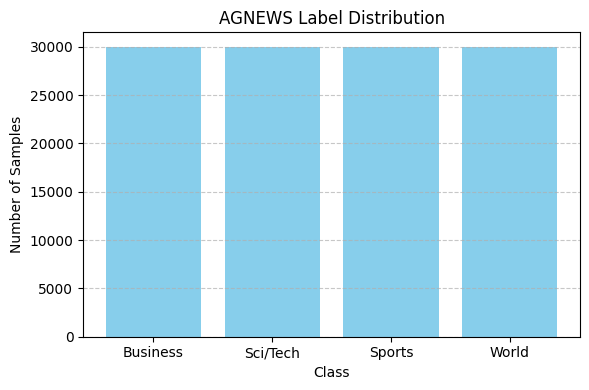


Sample 0:
Label: 2 (Business)
Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\b...
Sample 1:
Label: 2 (Business)
Text: Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,...
Sample 2:
Label: 2 (Business)
Text: Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about th...

Tokenized dataset size: 120000
Tokenized dataset features: {'labels': ClassLabel(names=['World', 'Sports', 'Business', 'Sci/Tech'], id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

Tokenized Sample Example:
  Label: 2
  Input IDs length: 316
  Attention mask length: 316

=====  =====
Dataset split has not been performed yet.


In [3]:
# Extract the number of classess and their names
num_labels = dataset.features['label'].num_classes
class_names = dataset.features["label"].names
print(f"Number of labels: {num_labels}")
print(f"The labels: {class_names}")
# 
print("\n==========")
print(f"Length of the dataset: {len(dataset)}")
print(f"Type of the dataset: {type(dataset)}")
print(f"Dataset Features: {dataset.features}")

# 
label_counts = {}
for item in dataset:
    label = item["label"]
    if label in label_counts:
        label_counts[label] += 1
    else:
        label_counts[label] = 1

print("\n Label Distribution :", label_counts)
print(f"Number of Tags: {sum(label_counts.values())}")

labels = list(label_counts.keys())
values = list(label_counts.values())
label_names = [class_names[i] for i in labels]

plt.figure(figsize=(6, 4))
plt.bar(label_names, values, color='skyblue')
plt.title("AGNEWS Label Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


print("\n==========")
for i in range(3):
    example = dataset[i]
    print(f"Sample {i}:")
    print(f"Label: {example['label']} ({class_names[example['label']]})")
    print(f"Text: {example['text'][:100]}...")
    
# 
print("\n==========")
print(f"Tokenized dataset size: {len(tokenized_dataset)}")
print(f"Tokenized dataset features: {tokenized_dataset.features}")

# 
tokenized_example = tokenized_dataset[0]
print("\nTokenized Sample Example:")
print(f"  Label: {tokenized_example['labels']}")
print(f"  Input IDs length: {len(tokenized_example['input_ids'])}")
print(f"  Attention mask length: {len(tokenized_example['attention_mask'])}")
# 
print("\n=====  =====")
# train_test_split，，
if 'split_datasets' in locals() or 'split_datasets' in globals():
    print(f"Training set size: {len(train_dataset)}")
    print(f"Validation set size: {len(eval_dataset)}")
    
    # 
    train_label_counts = {}
    for item in train_dataset:
        label = item["labels"]
        if label in train_label_counts:
            train_label_counts[label] += 1
        else:
            train_label_counts[label] = 1
            
    eval_label_counts = {}
    for item in eval_dataset:
        label = item["labels"]
        if label in eval_label_counts:
            eval_label_counts[label] += 1
        else:
            eval_label_counts[label] = 1
    
    print("\nTraining set label distribution:", train_label_counts)
    print("Validation set label distribution:", eval_label_counts)
else:
    print("Dataset split has not been performed yet.")
# Create an id2label mapping
# We will need this for our classifier.
id2label = {i: label for i, label in enumerate(class_names)}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

In [4]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
model = RobertaForSequenceClassification.from_pretrained(
    base_model,
    id2label=id2label)
model

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [5]:
split_datasets = tokenized_dataset.train_test_split(test_size=640, seed=42)
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']



# 
# split_datasets = tokenized_dataset.train_test_split(test_size=640, seed=42)

# （10%）
# small_dataset = tokenized_dataset.shuffle(seed=42).select(range(12000))  # 10%
# split_datasets = small_dataset.train_test_split(test_size=640, seed=42)
# train_dataset = split_datasets['train']
# eval_dataset = split_datasets['test']

print(f"Training set size reduced from {len(tokenized_dataset)} to {len(train_dataset)}")

Training set size reduced from 120000 to 119360


In [6]:
# PEFT Config
peft_config = LoraConfig(
    r=2,
    lora_alpha=8,
    lora_dropout=0.05,
    bias = 'none',
    target_modules = ['query', 'key', 'value'],
    task_type="SEQ_CLS",
)

In [7]:
peft_model = get_peft_model(model, peft_config)
# 
print("\n===== Model Parameter Check =====")

# 
print("Trainable parameters in the model:")
total_params = 0
trainable_params = 0
for name, param in peft_model.named_parameters():
    param_count = param.numel()
    total_params += param_count
    if param.requires_grad:
        trainable_params += param_count
        print(f"Trainable parameter: {name}, Shape: {param.shape}, Count: {param_count}")


print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Trainable parameter ratio: {trainable_params/total_params*100:.2f}%")

# 
print("\n===== Model Output Check =====")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dummy_input = tokenizer("This is a test text for model prediction", return_tensors="pt").to(device)
peft_model = peft_model.to(device)

with torch.no_grad():
    outputs = peft_model(**dummy_input)
    print("Model output shape:", outputs.logits.shape)  # Should be [1, 4]
    print("Model output values:", outputs.logits)
peft_model


===== Model Parameter Check =====
Trainable parameters in the model:
Trainable parameter: base_model.model.roberta.encoder.layer.0.attention.self.query.lora_A.default.weight, Shape: torch.Size([2, 768]), Count: 1536
Trainable parameter: base_model.model.roberta.encoder.layer.0.attention.self.query.lora_B.default.weight, Shape: torch.Size([768, 2]), Count: 1536
Trainable parameter: base_model.model.roberta.encoder.layer.0.attention.self.key.lora_A.default.weight, Shape: torch.Size([2, 768]), Count: 1536
Trainable parameter: base_model.model.roberta.encoder.layer.0.attention.self.key.lora_B.default.weight, Shape: torch.Size([768, 2]), Count: 1536
Trainable parameter: base_model.model.roberta.encoder.layer.0.attention.self.value.lora_A.default.weight, Shape: torch.Size([2, 768]), Count: 1536
Trainable parameter: base_model.model.roberta.encoder.layer.0.attention.self.value.lora_B.default.weight, Shape: torch.Size([768, 2]), Count: 1536
Trainable parameter: base_model.model.roberta.encode

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.05, inplace=False)
                    )
                    (lora_A): Mo

In [8]:
print('PEFT Model')
peft_model.print_trainable_parameters()


PEFT Model
trainable params: 704,260 || all params: 125,352,968 || trainable%: 0.5618


In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)
    return {
        'accuracy': accuracy
    }

In [10]:
output_dir = "results"
training_args = TrainingArguments(
    output_dir=output_dir,
    report_to=None,
    eval_strategy='steps',
    logging_steps=20,
    # eval_steps=100,
    eval_steps=50,     #     
    learning_rate=1e-1,
    num_train_epochs=1,
    # max_steps=1200,
    max_steps=1200,     # 200    
    use_cpu=False,
    dataloader_num_workers=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    optim="sgd",
    disable_tqdm=False, 
    logging_first_step=True,
    logging_dir="./logs",
    gradient_checkpointing=False,
    gradient_checkpointing_kwargs={'use_reentrant':True}
)

print("\n===== Training Argument Check =====")
print(f"Optimizer: {training_args.optim}")
print(f"Learning Rate: {training_args.learning_rate}")
print(f"Training Batch Size: {training_args.per_device_train_batch_size}")
print(f"Max Training Steps: {training_args.max_steps}")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

from transformers import Trainer as OriginalTrainer

class CustomTrainer(OriginalTrainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # Trainer.training_step
        # num_items_in_batch
        if "num_items_in_batch" in kwargs:
            pass  # 
        if "num_items_in_batch" in inputs:
            del inputs["num_items_in_batch"]
        return super().compute_loss(model, inputs, return_outputs)

    def training_step(self, model, inputs, *args, **kwargs):
        loss = super().training_step(model, inputs, *args, **kwargs)
        # 10
        if self.state.global_step % 10 == 0:
            print(f"Step {self.state.global_step}: Loss = {loss.item():.4f}")
        return loss

from transformers import TrainerCallback

class LoggingCallback(TrainerCallback):
    def __init__(self, log_interval=20):
        self.log_interval = log_interval
        
    def on_step_end(self, args, state, control, **kwargs):
        if state.global_step % self.log_interval == 0:
            print(f"Step: {state.global_step}, Loss: {state.log_history[-1]['loss'] if len(state.log_history) > 0 else 'N/A'}")

# Trainer
callbacks = [LoggingCallback(log_interval=20)]

# get_trainerCustomTrainerTrainer
def get_trainer(model):
      return CustomTrainer(
          model=model,
          args=training_args,
          compute_metrics=compute_metrics,
          train_dataset=train_dataset,
          eval_dataset=eval_dataset,
          data_collator=data_collator,
      )


===== Training Argument Check =====
Optimizer: OptimizerNames.SGD
Learning Rate: 0.1
Training Batch Size: 16
Max Training Steps: 1200
Device: GPU


In [11]:
import torch
print("✅ CUDA Available:", torch.cuda.is_available())
print("🔧 Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

✅ CUDA Available: True
🔧 Device: NVIDIA GeForce RTX 4070 Laptop GPU


In [12]:
peft_lora_finetuning_trainer = get_trainer(peft_model)
result = peft_lora_finetuning_trainer.train()

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step 0: Loss = 1.3491


Step,Training Loss,Validation Loss,Accuracy
50,1.461500,1.399994,0.287500
100,1.249000,0.708606,0.829688
150,0.507700,0.356567,0.889062
200,0.340100,0.460840,0.859375
250,0.389900,0.710545,0.715625
300,0.344000,0.370882,0.881250
350,0.346600,0.339674,0.896875
400,0.310800,0.314972,0.903125
450,0.279800,0.314900,0.903125
500,0.275300,0.315467,0.903125


Step 10: Loss = 1.7011
Step 20: Loss = 1.3980
Step 30: Loss = 1.4501
Step 40: Loss = 1.3437
Step 50: Loss = 1.3106
Step 60: Loss = 1.3645
Step 70: Loss = 1.4210
Step 80: Loss = 1.3824
Step 90: Loss = 1.2976
Step 100: Loss = 0.6184
Step 110: Loss = 0.7957
Step 120: Loss = 0.4756
Step 130: Loss = 0.5257
Step 140: Loss = 0.3982
Step 150: Loss = 0.5933
Step 160: Loss = 0.4359
Step 170: Loss = 0.4052
Step 180: Loss = 0.2699
Step 190: Loss = 0.2553
Step 200: Loss = 0.3823
Step 210: Loss = 0.3849
Step 220: Loss = 1.1822
Step 230: Loss = 0.2283
Step 240: Loss = 0.1075
Step 250: Loss = 0.3853
Step 260: Loss = 0.1216
Step 270: Loss = 0.1985
Step 280: Loss = 0.1201
Step 290: Loss = 0.2470
Step 300: Loss = 0.7313
Step 310: Loss = 0.6111
Step 320: Loss = 0.9019
Step 330: Loss = 0.5611
Step 340: Loss = 0.2436
Step 350: Loss = 0.1639
Step 360: Loss = 0.2257
Step 370: Loss = 0.5001
Step 380: Loss = 0.0965
Step 390: Loss = 0.4998
Step 400: Loss = 0.0655
Step 410: Loss = 0.5994
Step 420: Loss = 0.1703
S

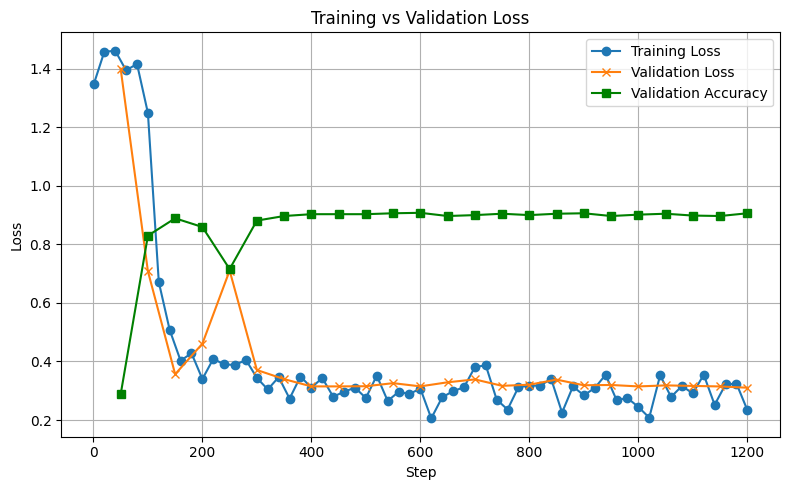

In [13]:
training_logs = peft_lora_finetuning_trainer.state.log_history

train_steps = [log["step"] for log in training_logs if "loss" in log]
train_losses = [log["loss"] for log in training_logs if "loss" in log]
eval_steps = [log["step"] for log in training_logs if "eval_loss" in log]
eval_losses = [log["eval_loss"] for log in training_logs if "eval_loss" in log]

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(train_steps, train_losses, label="Training Loss", marker='o')
plt.plot(eval_steps, eval_losses, label="Validation Loss", marker='x')
val_steps = [log["step"] for log in training_logs if "eval_accuracy" in log]
val_accuracies = [log["eval_accuracy"] for log in training_logs if "eval_accuracy" in log]

plt.plot(val_steps, val_accuracies, label="Validation Accuracy", marker='s', color='green')
plt.title("Training vs Validation Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm

def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    """
    Evaluate a PEFT model on a dataset.

    Args:
        inference_model: The model to evaluate.
        dataset: The dataset (Hugging Face Dataset) to run inference on.
        labelled (bool): If True, the dataset includes labels and metrics will be computed.
                         If False, only predictions will be returned.
        batch_size (int): Batch size for inference.
        data_collator: Function to collate batches. If None, the default collate_fn is used.

    Returns:
        If labelled is True, returns a tuple (metrics, predictions)
        If labelled is False, returns the predictions.
    """
    # Create the DataLoader
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()

    all_predictions = []
    if labelled:
        metric = evaluate.load('accuracy')

    # Loop over the DataLoader
    for batch in tqdm(eval_dataloader):
        # Move each tensor in the batch to the device
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        all_predictions.append(predictions.cpu())

        if labelled:
            # Expecting that labels are provided under the "labels" key.
            references = batch["labels"]
            metric.add_batch(
                predictions=predictions.cpu().numpy(),
                references=references.cpu().numpy()
            )

    # Concatenate predictions from all batches
    all_predictions = torch.cat(all_predictions, dim=0)

    if labelled:
        eval_metric = metric.compute()
        print("Evaluation Metric:", eval_metric)
        return eval_metric, all_predictions
    else:
        return all_predictions

In [15]:
eval_metric, _ = evaluate_model(peft_model, eval_dataset, True, 8, data_collator)
print(f"\n✅ Final Validation Accuracy: {eval_metric['accuracy']:.4f}")

100%|██████████| 80/80 [00:33<00:00,  2.36it/s]

Evaluation Metric: {'accuracy': 0.90625}

✅ Final Validation Accuracy: 0.9062


100%|██████████| 80/80 [00:34<00:00,  2.33it/s]


Evaluation Metric: {'accuracy': 0.90625}


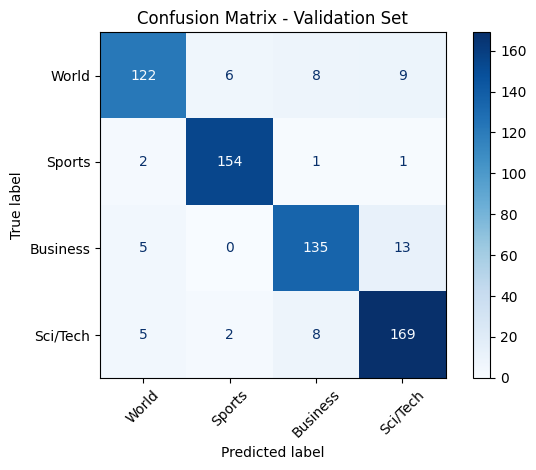

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Run evaluation to get predictions
_, preds = evaluate_model(peft_model, eval_dataset, True, 8, data_collator)

# Extract true labels
true_labels = [example['labels'] for example in eval_dataset]

# Create confusion matrix
cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Validation Set")
plt.tight_layout()
plt.show()

In [17]:
unlabelled_dataset = pd.read_pickle("test_unlabelled.pkl")
print(f"Test set type: {type(unlabelled_dataset)}")
print(f"Test set shape: {unlabelled_dataset.shape if hasattr(unlabelled_dataset, 'shape') else 'Unknown'}")


# Dataset
if isinstance(unlabelled_dataset, Dataset):
    test_dataset = unlabelled_dataset
else:
    # DataFrame，Dataset
    test_dataset = Dataset.from_pandas(unlabelled_dataset)

# 
if 'text' in test_dataset.features:
    test_dataset = test_dataset.map(preprocess, batched=True, remove_columns=["text"])
else:
    print("Warning: 'text' column not found in test set. Please check the field names.")
    # 
    print(f"Test set features: {test_dataset.features}")

Test set type: <class 'datasets.arrow_dataset.Dataset'>
Test set shape: (8000, 1)


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

In [18]:
preds = evaluate_model(peft_model, test_dataset, False, 8, data_collator)
df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds.numpy()  # tensornumpy
})
output_path = os.path.join(output_dir, "inference_output.csv")
df_output.to_csv(output_path, index=False)
print(f"Inference complete. Predictions saved to {output_path}")

# 
print("\nSample predictions (first 5 rows):")
print(df_output.head())

100%|██████████| 1000/1000 [05:19<00:00,  3.13it/s]

Inference complete. Predictions saved to results\inference_output.csv

Sample predictions (first 5 rows):
   ID  Label
0   0      3
1   1      0
2   2      0
3   3      3
4   4      1
